In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import random
import math
#preprocessing and regression model
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
import hyperopt
from hyperopt.pyll import scope
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

from sklearn.inspection import permutation_importance
#visualization
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


In [2]:
#set seed for repeatability
seed=60

#dataframe loading and slice
df = pd.read_csv('https://github.com/aveucoloap/Machine-Learning-corrosion-study/blob/main/test_imidazole_Rev6.csv')#20 compounds
#Split trainval and Test data
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = seed)#splits 16 compounds to trainval and 4 compounds to test
split = splitter.split(df, groups=df['Ionization Potential'])
train_inds, test_inds = next(split)
#define trainval and test dataframes

trainval_unindexed = df.iloc[train_inds]
tv = trainval_unindexed.reset_index()
trainval=tv.drop(['index'],axis=1)
test_unindexed = df.iloc[test_inds]
tst = test_unindexed.reset_index()
test = tst.drop(['index'],axis=1)

In [3]:
X_trainval = trainval.drop(['comp_ref','IE'],axis=1)
Y_trainval = trainval['IE']

X_test = test.drop(['comp_ref','IE'],axis=1)
Y_test = test['IE']

In [4]:
#CV splitting based on Z group label with Leave One Group Out cv
cv = LeaveOneGroupOut()
cv.get_n_splits(X_trainval,Y_trainval,groups=trainval['Ionization Potential'])
for train_index, val_index in cv.split(X=X_trainval, y=Y_trainval, groups=trainval['Ionization Potential']):
    X_train, Y_train = X_trainval.iloc[train_index,:], Y_trainval[train_index]
    X_val, Y_val = X_trainval.iloc[val_index,:], Y_trainval[val_index]
    print(Y_val)#splitting check for validation data. Should be splitted to 16 folds/compounds for LOOCV since there are 16 compounds in the train-val split

139    89.333333
140    91.100000
141    94.633333
142    96.050000
143    94.400000
144    92.400000
145    90.400000
Name: IE, dtype: float64
52    67.010
53    73.315
54    73.995
55    77.135
Name: IE, dtype: float64
132    90.666667
133    92.866667
134    93.100000
135    94.425000
136    92.900000
137    90.900000
138    89.400000
Name: IE, dtype: float64
123    36.895
124    44.570
125    51.480
126    62.505
127    50.410
128    46.290
129    40.360
130    34.730
131    51.525
Name: IE, dtype: float64
82    53.815
83    67.460
84    78.105
85    83.930
86    88.520
Name: IE, dtype: float64
92     87.70
93     88.10
94     91.10
95     91.20
96     92.35
97     92.00
98     93.75
99     94.20
100    91.20
101    88.30
102    85.10
Name: IE, dtype: float64
15    61.95
16    93.70
17    85.95
18    96.70
19    91.95
20    97.60
21    92.15
22    97.70
23    93.90
24    93.35
25    97.80
26    97.80
27    95.70
28    91.50
29    87.24
Name: IE, dtype: float64
0     79.85
1     93.

In [5]:
#parameter search space for hyperopt. # max_samples is set to default(None). Since the dataset is small, it is better to draw all the samples to train each base estimator. Setting a value eventually makes the model choose dominant features and disregards other features when creating another base estimator

param_space = {'eta': hp.uniform('eta', 0.0,0.5),
        'gamma': hp.uniform ('gamma', 0.0,0.1),
        'max_depth': scope.int(hp.quniform("max_depth", 10, 100, 1)),
        'min_child_weight' : hp.uniform('min_child_weight', 0.001, 0.01), 
        'max_delta_step' :hp.uniform("max_delta_step", 5.0, 10.0),
        'subsample':hp.uniform('subsample', 0.5,1.0),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.0,1.0,0.05),
        'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.0,1.0,0.05),
        'colsample_bynode' : hp.quniform('colsample_bynode', 0.0,1.0,0.05),
        'reg_lambda' : hp.uniform('reg_lambda', 0.0,1.0),
        'reg_alpha' : hp.uniform('reg_alpha', 0.0,2.0),
        'n_estimators': scope.int(hp.quniform('n_estimators', 10, 100, 1)),
                }

LOOCV - Hyperopt function

In [6]:
#objective function to be minimized for cv0

def objective(param_space):
    scaler = StandardScaler()
    model = XGBRegressor(eta=param_space['eta'],
                        gamma = param_space['gamma'],
                        max_depth = param_space['max_depth'],
                        min_child_weight= param_space['min_child_weight'],
                        max_delta_step = param_space['max_delta_step'],
                        subsample = param_space['subsample'],
                        colsample_bytree = param_space['colsample_bytree'],
                        colsample_bylevel = param_space['colsample_bylevel'],
                        colsample_bynode = param_space['colsample_bynode'],
                        reg_lambda= param_space['reg_lambda'],
                        reg_alpha = param_space['reg_alpha'],
                        n_estimators = param_space['n_estimators'],
                        seed=seed, importance_type=('weight')
                        )
    pipeline = Pipeline([('scaler', scaler), ('estimator', model)]) #according to the documentation, this pipeline scaling process does not leak the test set in to the train set since the cv is predefined.            
    rmse = cross_val_score(pipeline, X_trainval, Y_trainval, cv = cv, groups=trainval['Ionization Potential'], scoring = 'neg_root_mean_squared_error',error_score='raise', n_jobs=-1).mean()


    # the algorithm maximizes the loss so the loss function in negative
    return {'loss': -rmse, 'status': STATUS_OK }

In [7]:
#optimization run on 10000 max_evals for cv0
trials = Trials()
best_cv0 = fmin(fn= objective,
            space= param_space,
            algo=tpe.suggest,
            max_evals =200,
            trials= trials,
            rstate=np.random.default_rng(seed))#according to documentation, reproducibility of results is possible thru default_rng.
best_cv0

100%|██████████| 200/200 [01:34<00:00,  2.12trial/s, best loss: 14.661835914500701]


{'colsample_bylevel': 0.2,
 'colsample_bynode': 0.2,
 'colsample_bytree': 0.1,
 'eta': 0.36966360955258837,
 'gamma': 0.05393099807314641,
 'max_delta_step': 8.64727347132959,
 'max_depth': 97.0,
 'min_child_weight': 0.0022048072231833932,
 'n_estimators': 66.0,
 'reg_alpha': 1.1708822620696802,
 'reg_lambda': 0.13386346352552742,
 'subsample': 0.6581790564606412}

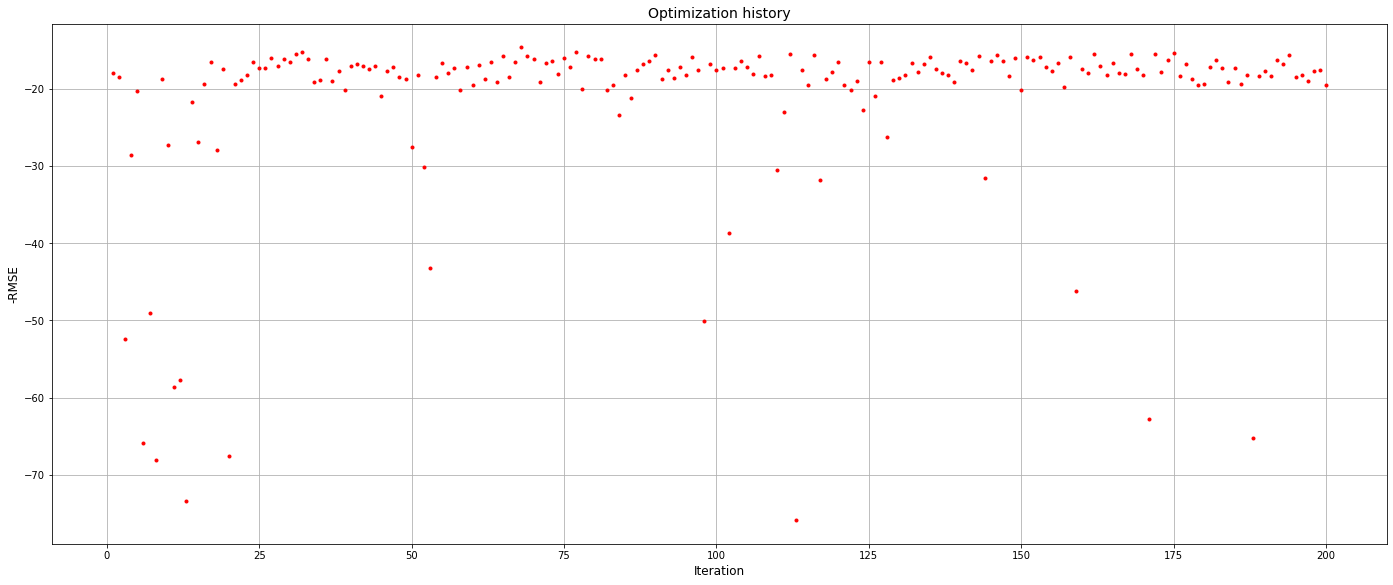

In [8]:
#  optimization history Plot

fig0 = plt.figure(figsize=(50, 20))
gs = gridspec.GridSpec(nrows=4, ncols=4)

ax = fig0.add_subplot(gs[:2, :2])
ax.plot(range(1, len(trials) + 1), [-x['result']['loss'] for x in trials], 
        color='red', marker='.', linewidth=0)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('-RMSE', fontsize=12)
ax.set_title('Optimization history', fontsize=14)

ax.grid(True)

In [9]:
#set variables for pltting hyperparameters and rmse
loss2=[t['result']['loss'] for t in trials.trials]
et=[t['misc']['vals']['eta'][0] for t in trials.trials]
gm=[t['misc']['vals']['gamma'][0] for t in trials.trials]
maxd2=[t['misc']['vals']['max_depth'][0] for t in trials.trials]
min_chld_wgt=[t['misc']['vals']['min_child_weight'][0] for t in trials.trials]
max_del_stp=[t['misc']['vals']['max_delta_step'][0] for t in trials.trials]
subsple=[t['misc']['vals']['subsample'][0] for t in trials.trials]
cltree = [t['misc']['vals']['colsample_bytree'][0] for t in trials.trials]
cllevel = [t['misc']['vals']['colsample_bylevel'][0] for t in trials.trials]
clnod = [t['misc']['vals']['colsample_bynode'][0] for t in trials.trials]
lmbda = [t['misc']['vals']['reg_lambda'][0] for t in trials.trials]
alph = [t['misc']['vals']['reg_alpha'][0] for t in trials.trials]
nest2=[t['misc']['vals']['n_estimators'][0] for t in trials.trials]

#passed as dataframe
hyperopt_xg=pd.DataFrame({'rmse':loss2,
                          'eta':et,
                          'gamma':gm,
                          'max_depth':maxd2,
                          'min_child_weight':min_chld_wgt,
                          'max_delta_step':max_del_stp,
                          'subsample':subsple,
                          'colsample_bytree':cltree,
                          'colsample_bylevel':cllevel,
                          'colsample_nod':clnod,
                          'reg_lambda':lmbda,
                          'reg_alpha':alph,                
                          'n_estimators':nest2,
                          })

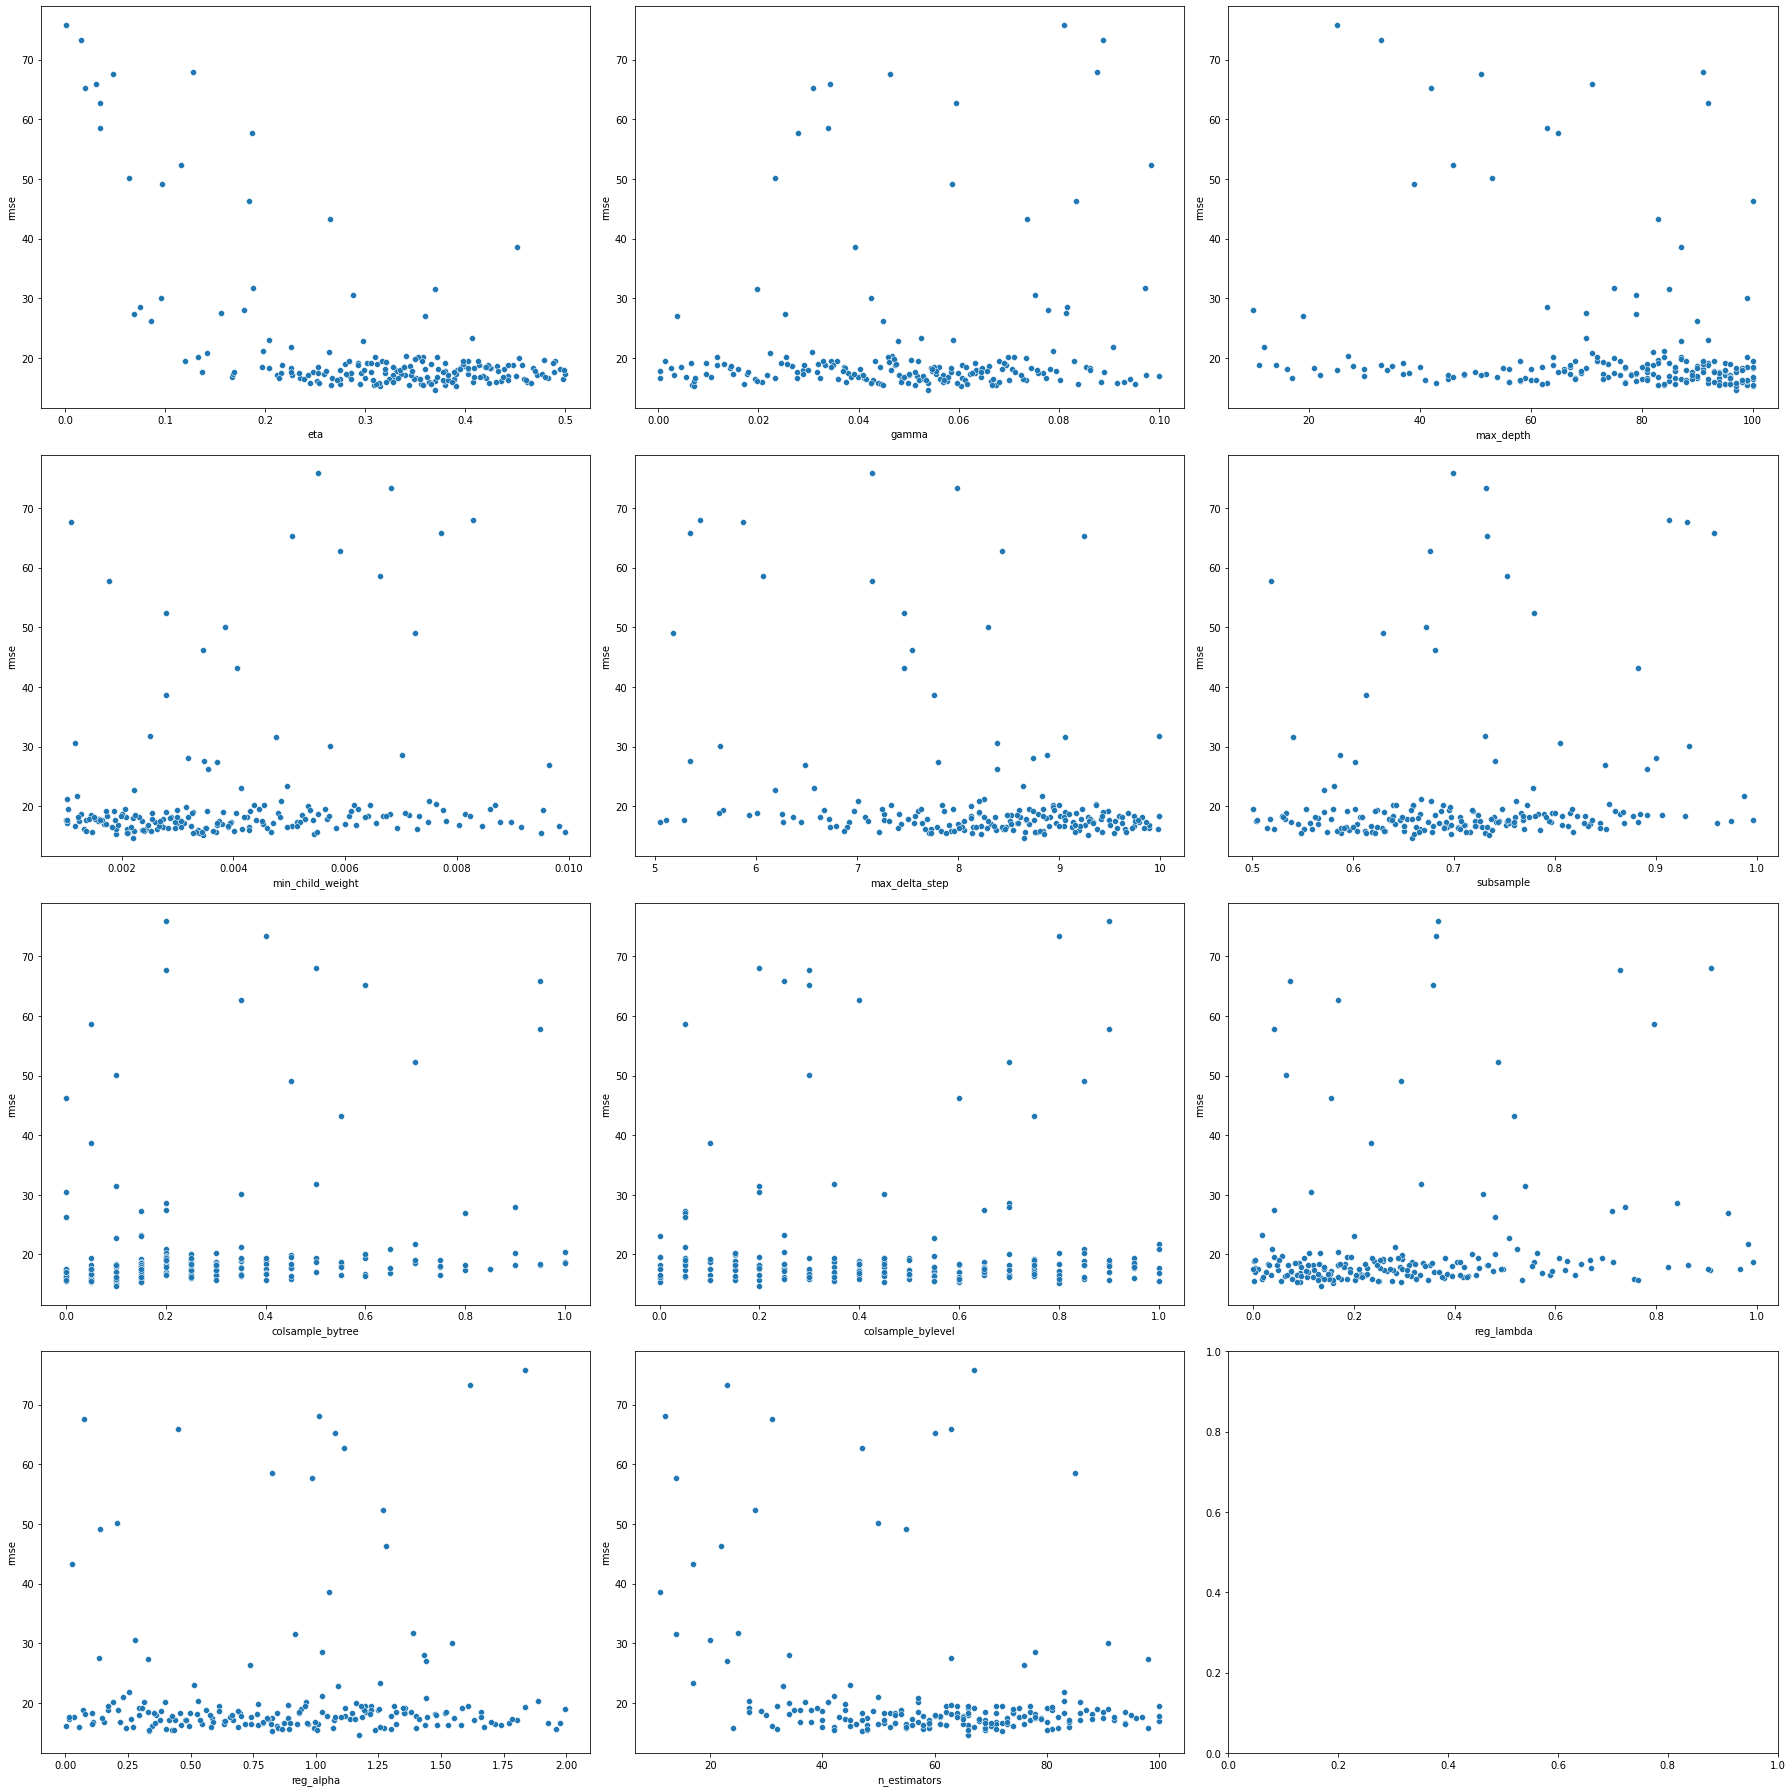

In [10]:
#Hyperparameters vs rmse plot
plt.subplots(4,3,figsize=(25,25))
plt.subplot(4,3,1)
sns.scatterplot(x='eta',y='rmse',data=hyperopt_xg)
plt.subplot(4,3,2)
sns.scatterplot(x='gamma',y='rmse',data=hyperopt_xg)
plt.subplot(4,3,3)
sns.scatterplot(x='max_depth',y='rmse',data=hyperopt_xg)
plt.subplot(4,3,4)
sns.scatterplot(x='min_child_weight',y='rmse',data=hyperopt_xg)
plt.subplot(4,3,5)
sns.scatterplot(x='max_delta_step',y='rmse',data=hyperopt_xg)
plt.subplot(4,3,6)
sns.scatterplot(x='subsample',y='rmse',data=hyperopt_xg)
plt.subplot(4,3,7)
sns.scatterplot(x='colsample_bytree',y='rmse',data=hyperopt_xg)
plt.subplot(4,3,8)
sns.scatterplot(x='colsample_bylevel',y='rmse',data=hyperopt_xg)
plt.subplot(4,3,9)
sns.scatterplot(x='reg_lambda',y='rmse',data=hyperopt_xg)
plt.subplot(4,3,10)
sns.scatterplot(x='reg_alpha',y='rmse',data=hyperopt_xg)
plt.subplot(4,3,11)
sns.scatterplot(x='n_estimators',y='rmse',data=hyperopt_xg)

plt.tight_layout()



array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

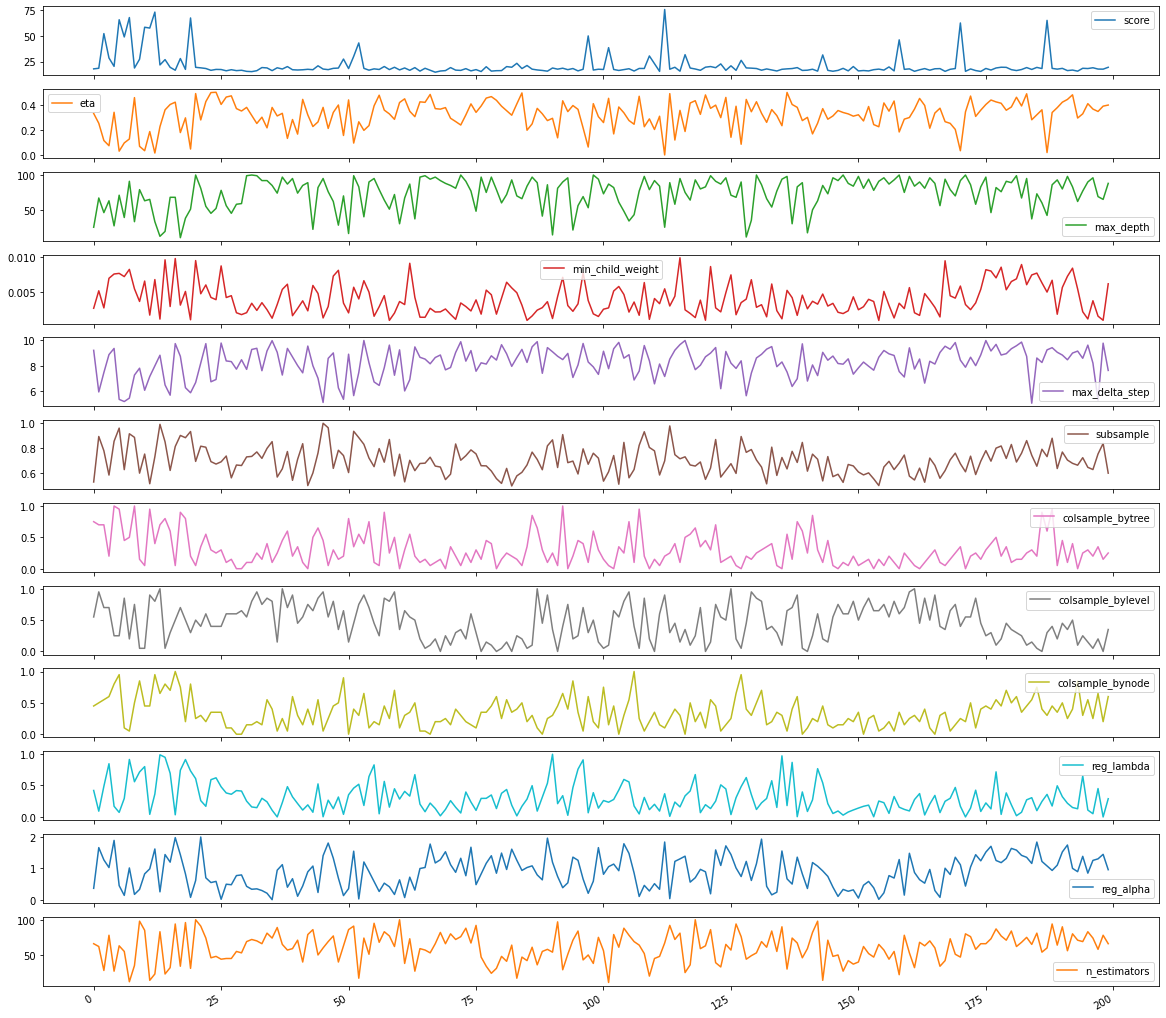

In [11]:
#Iteration vs Hyperparameter Plot
#shows that the iterations almost covered all of the search spaces defined.
sa_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['eta'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_child_weight'][0],
                      x['misc']['vals']['max_delta_step'][0],
                      x['misc']['vals']['subsample'][0],
                      x['misc']['vals']['colsample_bytree'][0],
                      x['misc']['vals']['colsample_bylevel'][0],
                      x['misc']['vals']['colsample_bynode'][0],
                      x['misc']['vals']['reg_lambda'][0],
                      x['misc']['vals']['reg_alpha'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

sa_results_df=pd.DataFrame(sa_results,
                           columns=['score','eta','max_depth','min_child_weight','max_delta_step','subsample','colsample_bytree', 'colsample_bylevel','colsample_bynode','reg_lambda','reg_alpha','n_estimators'])
sa_results_df.plot(subplots=True,figsize=(20, 20))

In [12]:
#Fitting X and Y with the best parameters in a base model.
XGBR_opt=XGBRegressor(eta=best_cv0['eta'],
                        gamma = best_cv0['gamma'],
                        max_depth = best_cv0['max_depth'].astype(int),
                        min_child_weight= best_cv0['min_child_weight'],
                        max_delta_step = best_cv0['max_delta_step'],
                        subsample = best_cv0['subsample'],
                        colsample_bytree = best_cv0['colsample_bytree'],
                        colsample_bylevel = best_cv0['colsample_bylevel'],
                        colsample_bynode = best_cv0['colsample_bynode'],
                        reg_lambda= best_cv0['reg_lambda'],
                        reg_alpha = best_cv0['reg_alpha'],
                        n_estimators = best_cv0['n_estimators'].astype(int),
                        seed=seed, importance_type=('weight')
                       )
standard_scaler = StandardScaler()
X_std_trainval= standard_scaler.fit_transform(X_trainval)
X_std_test = standard_scaler.transform(X_test)

In [13]:
XGBR_opt.fit(X_std_trainval,Y_trainval)
Y_pred = XGBR_opt.predict(X_std_trainval)
#Y predictions
Y_pred_trainval = XGBR_opt.predict(X_std_trainval)
Y_pred_test = XGBR_opt.predict(X_std_test)

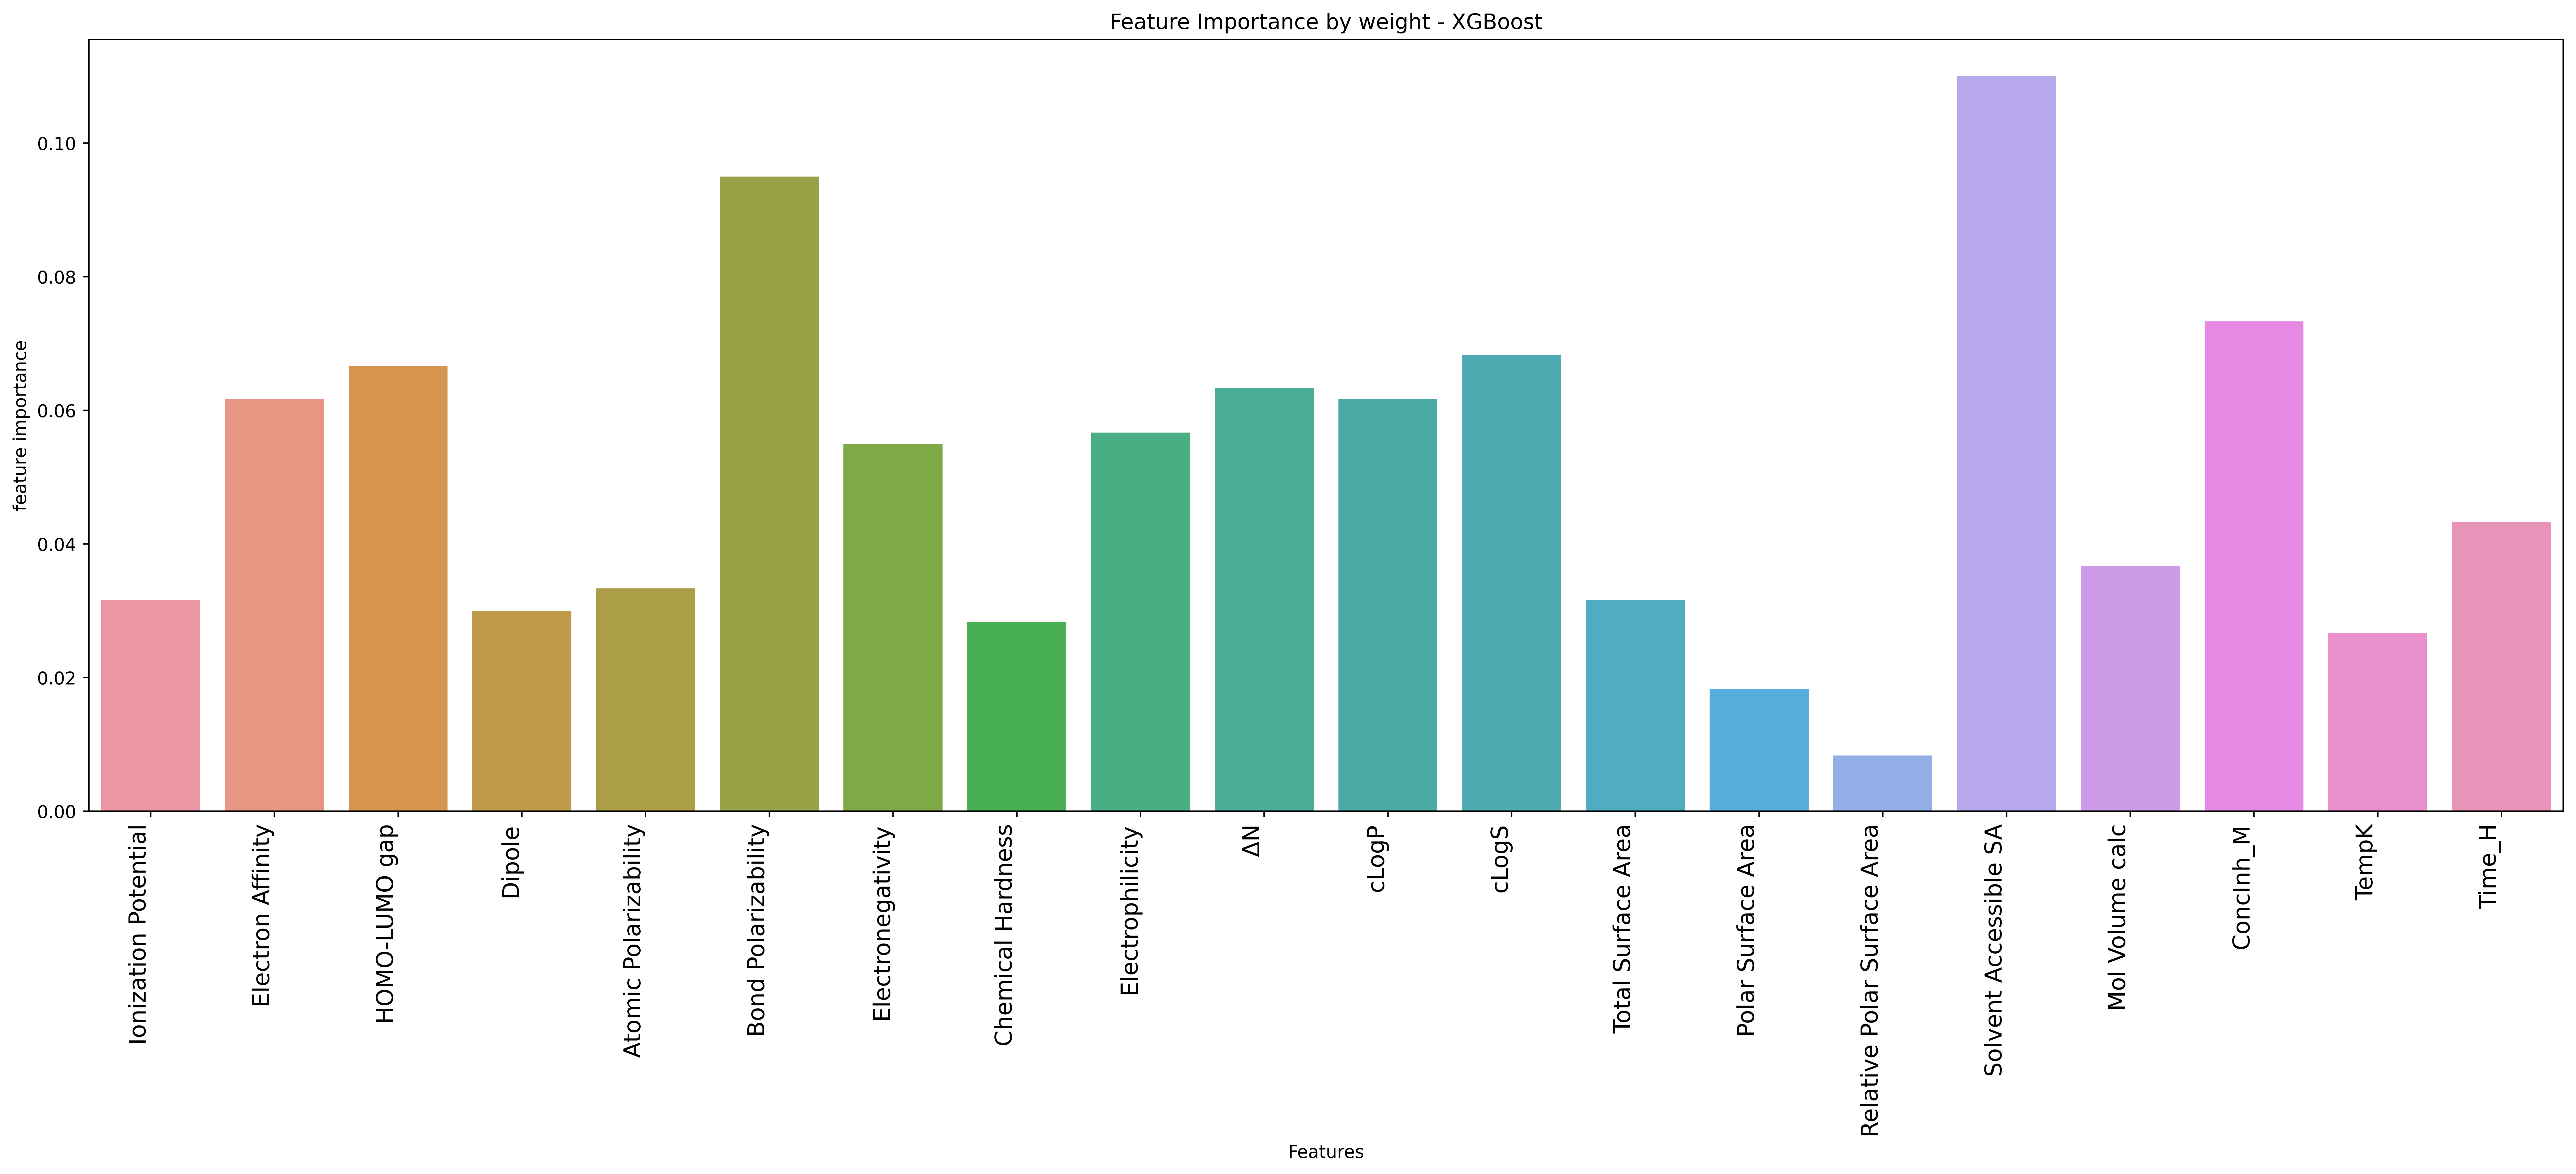

In [14]:
#plot feature importance
XGBR_opt.feature_importances_
f=plt.figure()
f.set_figwidth(25)
f.set_figheight(8)
f.set_dpi(500)
indexes = np.arange(len(X_trainval.columns))
width = 0.8
plt.title('Feature Importance by weight - XGBoost')
plt.xlabel('Features')
plt.xticks(indexes, X_train.columns, rotation=90, ha='right', fontsize=13)
plt.ylabel('feature importance')
sns.barplot(x=X_trainval.columns,y=XGBR_opt.feature_importances_)
plt.show()

<AxesSubplot:title={'center':'XGBoost IE-predicted values vs Experimental IE values'}, xlabel='IE values', ylabel='IE predicted values'>

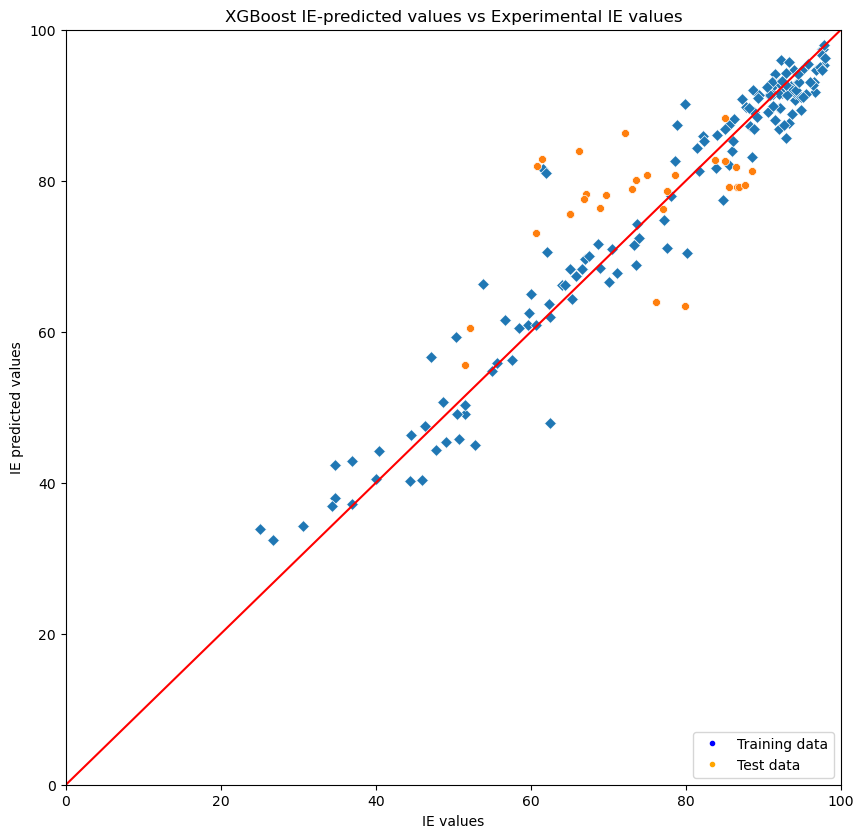

In [15]:
#plot Y-pred vs ytest
from matplotlib.lines import Line2D
f=plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
f.set_dpi(100)
plt.title('XGBoost IE-predicted values vs Experimental IE values')
plt.xlabel('IE values')
plt.ylabel('IE predicted values')
lims = [0, 100]
X_plot = np.linspace(0, 100)
Y_plot = np.linspace(0, 100)
plt.plot(X_plot, Y_plot, color='r')
plt.xlim(lims)
plt.ylim(lims)

custom = [Line2D([], [], marker='.', color='b', linestyle='None'),
          Line2D([], [], marker='.', color='orange', linestyle='None')]

plt.legend(custom, ['Training data', 'Test data'], loc='lower right')
sns.scatterplot(x=Y_trainval,y=Y_pred_trainval, marker="D", ci=None)
sns.scatterplot(x=Y_test,y=Y_pred_test, marker="8", ci=None)

In [16]:
#MAE and MSE for std scaler

MAE3  = mean_absolute_error(Y_test, Y_pred_test)
MSE3 = mean_squared_error(Y_test, Y_pred_test)
RMSE3= math.sqrt(MSE3)
R2_score3 = r2_score(Y_test, Y_pred_test)
Max_error3 = max_error(Y_test, Y_pred_test)
MAE4  = mean_absolute_error(Y_trainval, Y_pred_trainval)
MSE4 = mean_squared_error(Y_trainval, Y_pred_trainval)
RMSE4= math.sqrt(MSE4)
R2_score4 = r2_score(Y_trainval, Y_pred_trainval)
Max_error4 = max_error(Y_trainval, Y_pred_trainval)

#print table
table = [["Mean_absolute error", MAE3, MAE4 ],["Mean Square error", MSE3, MSE4],["Root Mean Square error", RMSE3, RMSE4], ["Max error", Max_error3, Max_error4], ["R2",R2_score3, R2_score4]] 

print(tabulate(table, headers=['Test', 'Training']))

                               Test    Training
----------------------  -----------  ----------
Mean_absolute error       8.59082       3.13878
Mean Square error       103.603        20.1907
Root Mean Square error   10.1786        4.49341
Max error                21.3895       19.9996
R2                        0.0574405     0.9467
